   Index    Asset1    Asset2    Asset3    Asset4
0      0  0.012495  0.011126  0.003252  0.006625
1      1  0.011439  0.002691  0.001206  0.006947
2      2  0.000632  0.007277  0.004049  0.000074
3      3  0.017828  0.028210  0.007758  0.007382
4      4  0.021115  0.019642  0.009238  0.011499
           Index      Asset1      Asset2      Asset3      Asset4
count  746.00000  746.000000  746.000000  746.000000  746.000000
mean   372.50000    0.013144    0.012822    0.009366    0.010788
std    215.49594    0.011914    0.011712    0.009283    0.009338
min      0.00000    0.000012    0.000057    0.000014    0.000067
25%    186.25000    0.004761    0.003878    0.003202    0.004226
50%    372.50000    0.010030    0.009423    0.006641    0.008508
75%    558.75000    0.017771    0.017810    0.012354    0.014221
max    745.00000    0.098709    0.088502    0.072016    0.074291


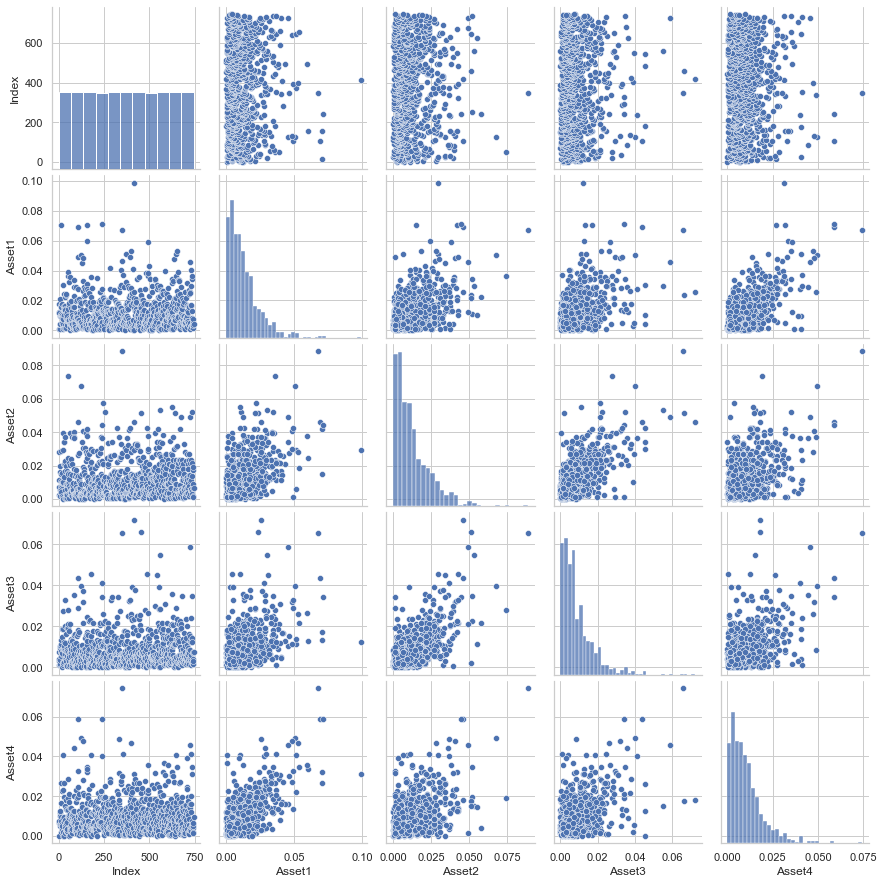

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from metrics import anderson_darling, kendall_error


# Load the dataset
file_path = "data_train_log_return.csv"
df = pd.read_csv(file_path, header=None, names=["Index", "Asset1", "Asset2", "Asset3", "Asset4"])

# Display the first few rows of the dataframe
print(df.head())

# Basic statistics of the dataset
print(df.describe())

# Pairplot for initial visualization
sns.pairplot(df)
plt.show()

In [79]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

# Split the dataset
train_data, test_data = train_test_split(df[["Asset1", "Asset2", "Asset3", "Asset4"]], test_size=0.2, random_state=42)

# Convert to PyTorch tensors
train_data = torch.tensor(train_data.values, dtype=torch.float32)
test_data = torch.tensor(test_data.values, dtype=torch.float32)

# Updated Generator
class Generator(nn.Module):
    def __init__(self, input_size, output_size):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 38),
            nn.ReLU(),
            # nn.Linear(64, 32),
            # nn.ReLU(),
            # nn.Linear(64, 32),
            # nn.ReLU(),
            # nn.Linear(256, output_size),
            # nn.Linear(input_size, 10),
            # nn.ReLU(),
            nn.Linear(38, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Updated Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            # nn.Linear(16, 10),
            # nn.ReLU(),
            # nn.Linear(64, 10),
            # nn.Linear(input_size, 10),
            # nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Hyperparameters
input_size = 100  # Size of random noise vector for the generator
output_size = 4   # Number of features in your dataset

# Create instances of the generator and discriminator
generator = Generator(input_size, output_size)
discriminator = Discriminator(output_size)

# Define loss function and optimizers
criterion = nn.BCELoss()
gen_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
disc_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)

In [80]:
# Training loop
num_epochs =1000
# batch_size = len(train_data)
batch_size = 100
# desired_mean = torch.mean(test_data[:, 0])
# desired_var = torch.var(test_data[:, 0])
loss_increase_threshold = 0.1  # Adjust as needed
# Initialize previous losses
prev_disc_loss = float('inf')
prev_gen_loss = float('inf')


for epoch in range(num_epochs):
    # ---------------------
    # Train Discriminator
    # ---------------------

    # Sample real data
    indices = torch.randint(0, len(train_data), (batch_size,))
    real_data = train_data[indices]
    
    
    # Generate fake data again
    # noise = torch.randn(batch_size, input_size) * desired_var**0.5 + desired_mean  # Ensure input_size matches the generator input size
    noise = torch.randn(batch_size, input_size)  # Ensure input_size matches the generator input size
    fake_data = generator(noise)
    
    

    # Labels for real and fake data
    real_labels = torch.ones((batch_size, 1))
    fake_labels = torch.zeros((batch_size, 1))

    # Train the discriminator
    disc_optimizer.zero_grad()
    real_pred = discriminator(real_data)
    fake_pred = discriminator(fake_data.detach())
    real_loss = criterion(real_pred, real_labels)
    fake_loss = criterion(fake_pred, fake_labels)
    total_disc_loss = real_loss + fake_loss
    total_disc_loss.backward()
    disc_optimizer.step()

    # ---------------------
    # Train Generator
    # ---------------------

    # Generate fake data again
    # noise = torch.randn(batch_size, input_size) * desired_var**0.5 + desired_mean
    noise = torch.randn(batch_size, input_size)
    # #Truncated noise
    # noise = torch.relu(noise)
    fake_data = generator(noise)

    # Train the generator
    gen_optimizer.zero_grad()
    gen_pred = discriminator(fake_data)
    gen_loss = criterion(gen_pred, real_labels)  # Generator wants to fool the discriminator
    gen_loss.backward()
    gen_optimizer.step()
    
    
    # Calculate the change in losses
    delta_disc_loss = total_disc_loss.item() - prev_disc_loss
    delta_gen_loss = gen_loss.item() - prev_gen_loss

    # Update the previous losses for the next iteration
    prev_disc_loss = total_disc_loss.item()
    prev_gen_loss = gen_loss.item()
    # Check if the losses are increasing beyond the threshold
    if delta_disc_loss > loss_increase_threshold or delta_gen_loss > loss_increase_threshold:
        print(f"Losses are increasing. Stopping training.")
        break

    # Print training stats
    if epoch % 50 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Disc Loss: {total_disc_loss.item()}, Gen Loss: {gen_loss.item()}")

# Training complete
print("GAN training completed!")


Epoch [0/1000], Disc Loss: 1.434278130531311, Gen Loss: 0.6434032917022705
Epoch [50/1000], Disc Loss: 1.404784917831421, Gen Loss: 0.678815484046936
Epoch [100/1000], Disc Loss: 1.373138666152954, Gen Loss: 0.7093904614448547
Epoch [150/1000], Disc Loss: 1.3414396047592163, Gen Loss: 0.7312244176864624
Epoch [200/1000], Disc Loss: 1.314786672592163, Gen Loss: 0.744688093662262
Epoch [250/1000], Disc Loss: 1.2981719970703125, Gen Loss: 0.7523360252380371
Epoch [300/1000], Disc Loss: 1.2898805141448975, Gen Loss: 0.7497828006744385
Epoch [350/1000], Disc Loss: 1.2892248630523682, Gen Loss: 0.745552659034729
Epoch [400/1000], Disc Loss: 1.303257703781128, Gen Loss: 0.735121488571167
Epoch [450/1000], Disc Loss: 1.314510464668274, Gen Loss: 0.7232508063316345
Epoch [500/1000], Disc Loss: 1.3318896293640137, Gen Loss: 0.7178442478179932
Epoch [550/1000], Disc Loss: 1.3450226783752441, Gen Loss: 0.7121646404266357
Epoch [600/1000], Disc Loss: 1.356874942779541, Gen Loss: 0.7082222700119019


In [81]:
# Set the generator in evaluation mode
generator.eval()

# Generate new samples
# num_samples = len(test_data) # Adjust as needed
num_samples = len(df) # Adjust as needed


# desired_mean = torch.mean(test_data[:, 0])
# desired_var = torch.var(test_data[:, 0])
#Change the noise 
# noise_for_generation = torch.randn(num_samples, input_size) * desired_var**0.5 + desired_mean 

noise_for_generation = torch.randn(num_samples, input_size)
# #Truncated noise
# noise_for_generation = torch.relu(noise_for_generation)


# # Set the desired mean for the exponential distribution
# # Calculate the rate parameter (lambda) from the desired mean
# rate_parameter = 1.0 / desired_mean
# # exp_noise = torch.empty(num_samples, 1).exponential_(rate_parameter)
# # noise_for_generation = torch.cat([exp_noise, torch.randn(num_samples, input_size - 1)], dim=1)
# exp_noise = torch.empty(num_samples, input_size).exponential_(rate_parameter)
# noise_for_generation = exp_noise

generated_samples = generator(noise_for_generation)

# Convert to a Pandas DataFrame for easy inspection
generated_df = pd.DataFrame(generated_samples.detach().numpy(), columns=["Asset1", "Asset2", "Asset3", "Asset4"])

# Display the generated samples
print("Generated Samples:")
print(generated_df)

Generated Samples:
       Asset1    Asset2    Asset3    Asset4
0    0.013737  0.002438  0.003179  0.006962
1    0.000730  0.013938  0.001003  0.000538
2    0.005204  0.006267  0.002992  0.005678
3    0.011229  0.031872  0.007143  0.017327
4    0.011038  0.008496  0.003785  0.006603
..        ...       ...       ...       ...
741  0.019289  0.015047  0.007497  0.025474
742  0.012278  0.008925  0.005471  0.013379
743  0.003095  0.028706  0.003688  0.009869
744  0.014516  0.009011  0.009277  0.028072
745  0.021974  0.008321  0.010442  0.017005

[746 rows x 4 columns]


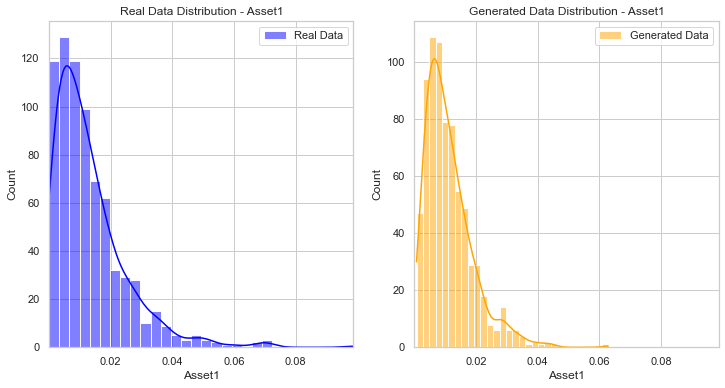

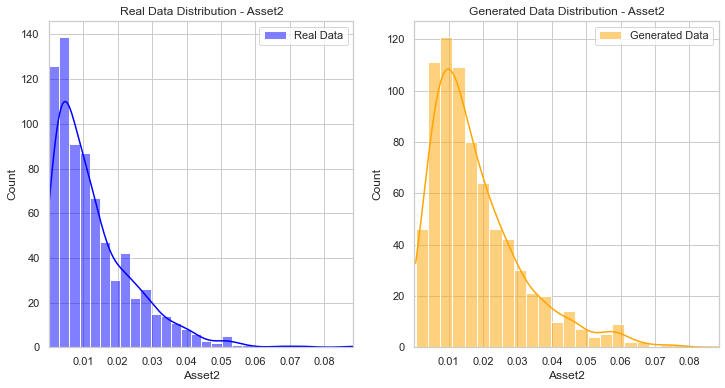

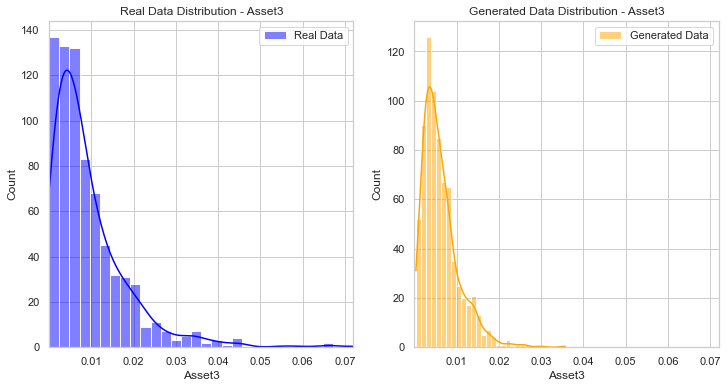

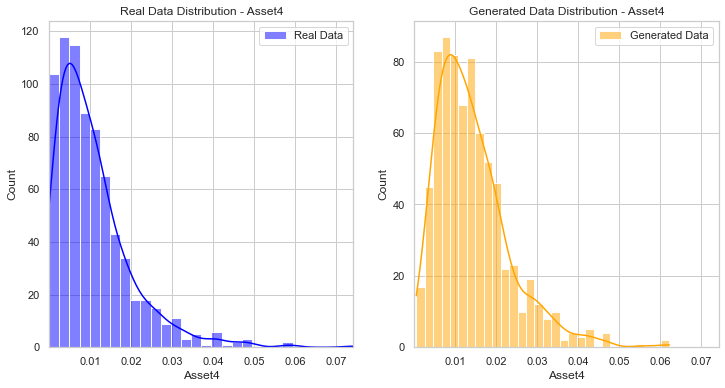

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better visuals
sns.set(style="whitegrid")

# plot_test_data = pd.DataFrame(test_data.detach().numpy(), columns=["Asset1", "Asset2", "Asset3", "Asset4"])
plot_test_data = df

# Plotting real vs generated distributions for each feature
for i, feature in enumerate(["Asset1", "Asset2", "Asset3", "Asset4"]):
    plt.figure(figsize=(12, 6))

    # Plot real data distribution
    plt.subplot(1, 2, 1)
    sns.histplot(plot_test_data[feature], bins=30, kde=True, color='blue', label='Real Data')
    plt.title(f"Real Data Distribution - {feature}")
    plt.legend()
    plt.xlim(plot_test_data[feature].min(), df[feature].max())

    # Plot generated data distribution
    plt.subplot(1, 2, 2)
    sns.histplot(generated_df[feature], bins=30, kde=True, color='orange', label='Generated Data')
    plt.title(f"Generated Data Distribution - {feature}")
    plt.legend()
    plt.xlim(plot_test_data[feature].min(), df[feature].max())

    plt.show()


In [83]:
anderson_darling(df.values, generated_df.values)

1020.7128609146827

In [84]:
kendall_error(df.values, generated_df.values)

0.09771668136099465

In [85]:
generated_df

,Asset1,Asset2,Asset3,Asset4
0,0.013737,0.002438,0.003179,0.006962
1,0.000730,0.013938,0.001003,0.000538
2,0.005204,0.006267,0.002992,0.005678
3,0.011229,0.031872,0.007143,0.017327
4,0.011038,0.008496,0.003785,0.006603
...,...,...,...,...
741,0.019289,0.015047,0.007497,0.025474
742,0.012278,0.008925,0.005471,0.013379
743,0.003095,0.028706,0.003688,0.009869
744,0.014516,0.009011,0.009277,0.028072


In [86]:
plot_test_data

,Index,Asset1,Asset2,Asset3,Asset4
0,0,0.012495,0.011126,0.003252,0.006625
1,1,0.011439,0.002691,0.001206,0.006947
2,2,0.000632,0.007277,0.004049,0.000074
3,3,0.017828,0.028210,0.007758,0.007382
4,4,0.021115,0.019642,0.009238,0.011499
...,...,...,...,...,...
741,741,0.001938,0.008833,0.003927,0.005106
742,742,0.005003,0.018943,0.003057,0.001988
743,743,0.007683,0.001958,0.007002,0.006467
744,744,0.003396,0.001280,0.007621,0.001680


In [87]:
# Save DataFrame to CSV file
generated_df.to_csv('generated_df.csv', index=False)

In [88]:
noise = pd.DataFrame(noise_for_generation.detach().numpy())
noise.to_csv('latent_variable.csv', index=False)